# Train Astro R-CNN

Train Mark R-CNN on PhoSim data

In [1]:
import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
import os
import random

# train
import train
from train import PhoSimDataset
from train import DESConfig

# mrcnn
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import utils

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN")
#OUT_DIR = os.path.abspath("./phosim_release/output/")
OUT_DIR = os.path.abspath("./trainingset/")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
#model path
model_path = os.path.join(MODEL_DIR, "astro_rcnn_des.h5")


%matplotlib inline


Using TensorFlow backend.


## Dataset

In [2]:
## Config

config = DESConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Create Model

In [3]:
## DATASET

# Training dataset
dataset_train = PhoSimDataset()
dataset_train.load_sources()
dataset_train.prepare()

# Validation dataset
dataset_val = PhoSimDataset()
dataset_val.load_sources(5)
dataset_val.prepare()

## Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


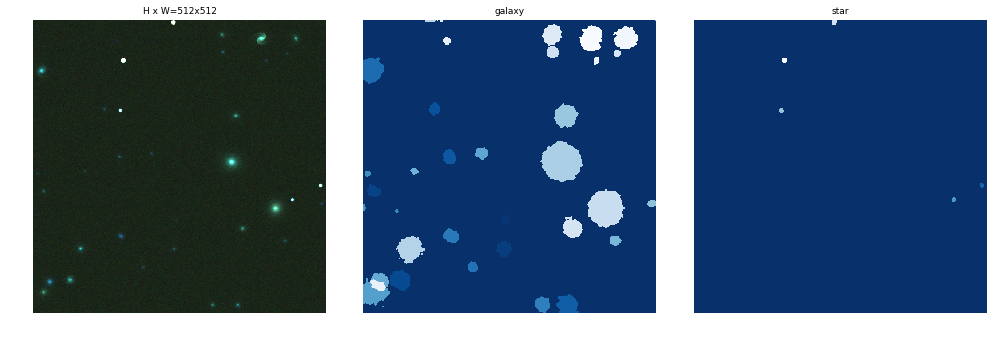

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


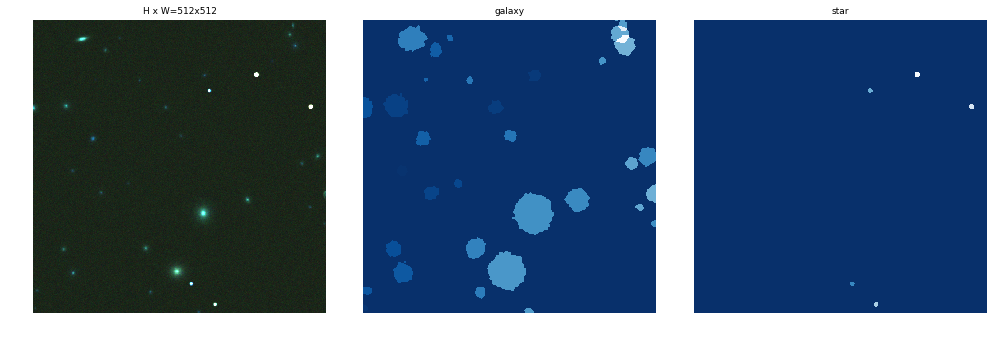

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


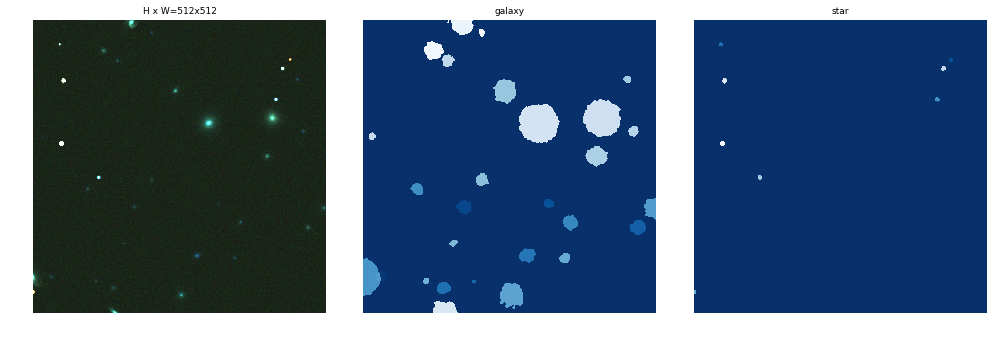

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    image_show = image.copy()
    image_show[:,:,2] = 0.6*image_show[:,:,2]
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image_show, mask, class_ids, dataset_train.class_names)

## CREATE MODEL

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])


In [5]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers='heads')

# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2,
            layers="all")

# Save weights
model.keras_model.save_weights(model_path)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/paleo2/Mask_R-CNN/deblend_maskrcnn/Mask_RCNN/logs/des20190529T2309/mask_rcnn_des_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistribute

/opt/apps/anaconda3/envs/powerai_env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
100/100 [==============================] - 811s 8s/step - loss: 3.7007 - rpn_class_loss: 0.5679 - rpn_bbox_loss: 1.1577 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 1.1380 - mrcnn_mask_loss: 0.7537 - val_loss: 2.1008 - val_rpn_class_loss: 0.2436 - val_rpn_bbox_loss: 0.7869 - val_mrcnn_class_loss: 0.0748 - val_mrcnn_bbox_loss: 0.5229 - val_mrcnn_mask_loss: 0.4726: 1.4740 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 1.7859 - mrcnn_mask_loss: 0.96 - ETA: 7:29 - loss: 5.1693 - rpn_class_loss: 0.9259 - rpn_bbox_loss: 1.4638 - mrcnn_class_loss: 0.0854 - mrcnn_bbox_loss: 1.7446 - mrcnn_mask_los - ETA: 6:13 - loss: 4.8224 - rpn_class_loss: 0.8275 - rpn_bbox_loss: 1.4034 - mrcnn_class_loss: 0.0872 - mrcnn_bbox_loss: 1.5994 - mrcnn_mas - ETA: 4:14 - loss: 4.3756 - rpn_class_loss: 0.7187 - rpn_bbox_loss: 1.3052 - mrcnn_class_loss: 0.0865 - mrcnn_bbox_loss: 1.4155 - mrcnn_mask_loss: 0 - ETA: 3:32 - loss: 4.2406 - rpn_class_loss: 0.6881 - rpn_bbox_loss: 1.2769 - mrcnn_class_loss: 0.0862

Epoch 2/2
100/100 [==============================] - 806s 8s/step - loss: 1.8713 - rpn_class_loss: 0.1956 - rpn_bbox_loss: 0.7430 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.4675 - val_loss: 1.7384 - val_rpn_class_loss: 0.2018 - val_rpn_bbox_loss: 0.7049 - val_mrcnn_class_loss: 0.0674 - val_mrcnn_bbox_loss: 0.3142 - val_mrcnn_mask_loss: 0.4501.0520 - rpn_class_loss: 0.2213 - rpn_bbox_loss: 0.7646 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.4947 - - ETA: 10:08 - loss: 2.0025 - rpn_class_loss: 0.2138 - rpn_bbox_loss: 0.7592 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.4631 - mrcnn_mask_loss - ETA: 9:04 - loss: 1.9744 - rpn_class_loss: 0.2066 - rpn_bbox_loss: 0.7554 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.4486 - mrcnn_mask_los - ETA: 7:45 - loss: 1.9569 - rpn_class_loss: 0.2042 - rpn_bbox_loss: 0.7598 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.4310 - mrcnn_mask_loss: 0 - ETA: 7:04 - loss: 1.9481 - rpn_class_loss: 0.2034 - rpn_bbox_loss: 0.

## Detection

In [5]:
class InferenceConfig(DESConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /home/paleo2/Mask_R-CNN/deblend_maskrcnn/Mask_RCNN/logs/des20190529T2309/mask_rcnn_des_0002.h5
Re-starting from epoch 2


original_image           shape: (512, 512, 3)         min:   11.00000  max: 65535.00000  uint32
image_meta               shape: (15,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (35,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (35, 4)               min:    0.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 35)        min:    0.00000  max:    1.00000  bool


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


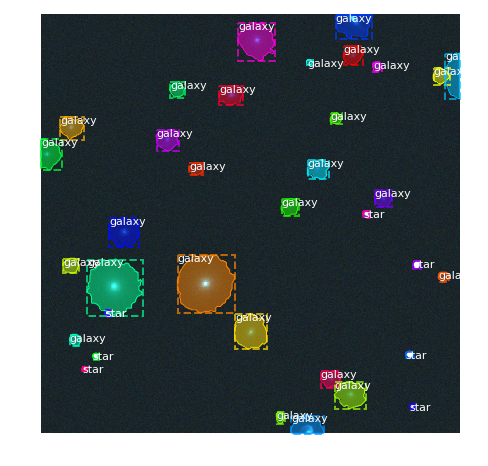

In [9]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max: 65535.00000  uint32
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max: 65431.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


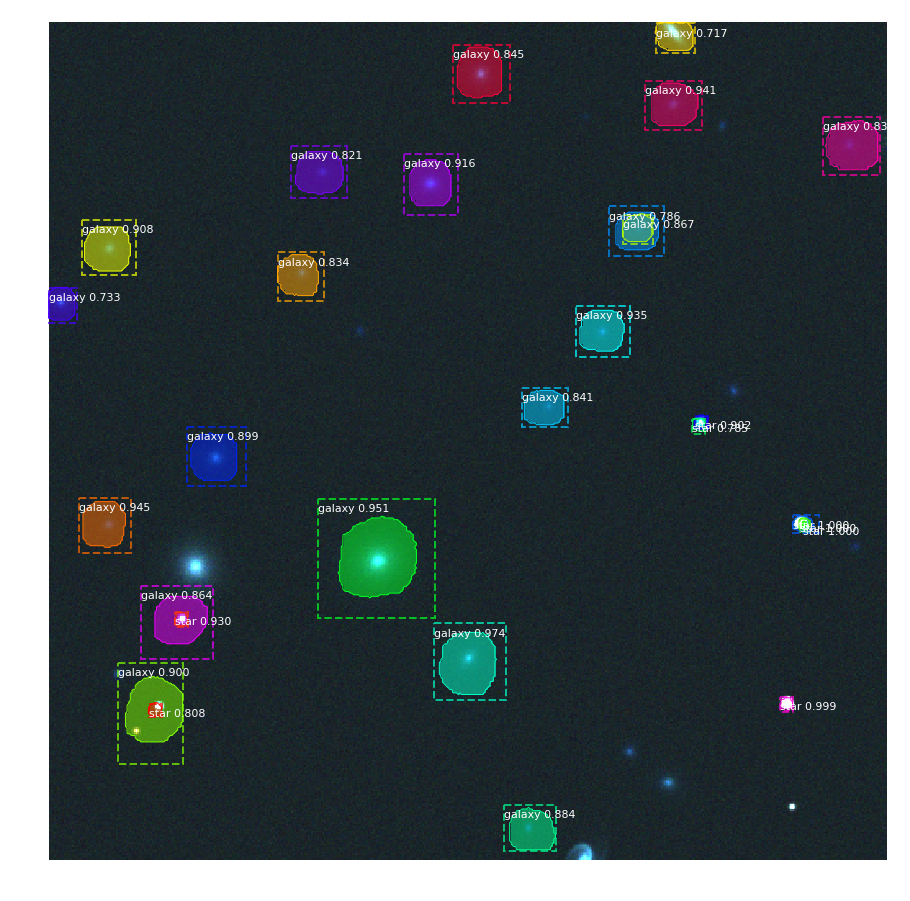

In [10]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

## Evaluation

In [11]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.3716515932507242
